# Internal-Gravity Waves

In this code we will solve the boussinesq equations linearized around a state of rest, which can be written in vector form as: 
$$
\frac{\partial \mathbf{u}}{\partial t} + \nabla \phi - b \hat{k} = 0
$$

$$
\nabla \cdot \mathbf{u} =0
$$

$$
\frac{\partial b}{\partial t} + N^2 \mathbf{u} \cdot \hat{k} = 0
$$

where $\mathbf{u} = (u, w)$ is the velocity in the 2D x-z plane, b is the buoyancy field, and $\phi$ is the dynamics pressure. $N^2$ is the background buoyancy field (constant here, but doesn't need to be in general). 

> For more context see section 2.10 in the Vallis book.


Here we will solve the equations for a simple scenario. 

Here we also add another equation, which explain the evolution of a passive tracer.
$$
\frac{\partial C}{\partial t} + \mathbf{u} \cdot \nabla C = \kappa \nabla^2 C
$$
This is the advection-diffusion equation. 


In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64

N2= 1 # You may need to change

dealias = 3/2
stop_sim_time = 75
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

kappa = 1

In [3]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-Lx, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(-Lz, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))
#w = dist.Field(name='w', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')

x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)

We will force the system with a time varying forcing (sinusoidal in time), which will be applied to a local region (localized using a gaussian). 

The goal will be to see how waves emanate from this forcing region. 

In [4]:
# Setup Forcing 
Fxz = dist.Field(name='Fxz', bases=(xbasis,zbasis))

sigma = 0.08 # sets the size of the forcing region.
Fxz['g'] = np.exp(-((x)**2 + (z)**2) / (2 * sigma**2))

t = dist.Field()
forcing_freq = 0.6*N2 # You may need to change (we are setting this relative to N2 for physical meangingfulness)
Ft = np.sin(forcing_freq*t)

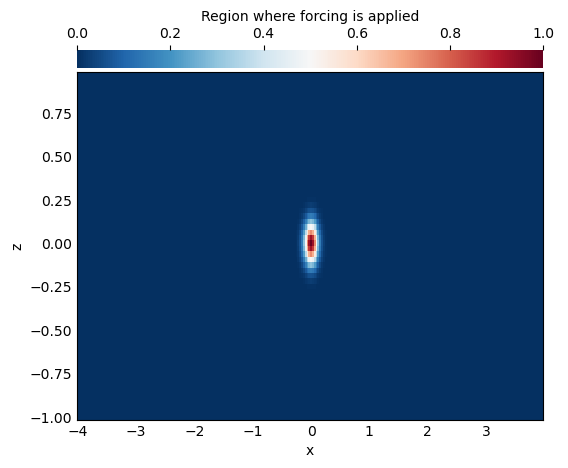

In [5]:
from dedalus.extras.plot_tools import plot_bot_2d
plot_bot_2d(Fxz,title="Region where forcing is applied");

In [6]:
problem = d3.IVP([p, b, u, tau_p, C], time=t, namespace=locals())

In principle the system can solved quite easily, using Dedalus. Notice that the equations are entered in almost readable form. 

>@ is the dot product, * is just simple multiplication. 

Also notice that we are applying the forcing only to the vertical momentum equation. 

In [7]:
problem.add_equation("dt(u) + grad(p) - b*ez = (Fxz*Ft)*ez")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("dt(b) + N2*(u@ez) = 0")
problem.add_equation("integ(p) = 0");
problem.add_equation("dt(C) - kappa*lap(C)= - u@grad(C)")

{'LHS': Add(dt(<Field 5197616592>), Mul(-1, Lap(<Field 5197616592>))),
 'RHS': Dot(Mul(-1, <Field 4593228368>), Grad(<Field 5197616592>)),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': <Field 5197616592>,
 'L': Mul(-1, Lap(<Field 5197616592>)),
 'F': Dot(Mul(-1, <Field 4593228368>), Grad(<Field 5197616592>)),
 'domain': <dedalus.core.domain.Domain at 0x135cd4c50>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False, False])}

In [8]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2025-02-19 11:57:08,029 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 4.3e+01/s
2025-02-19 11:57:08,230 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 5.8e+01/s
2025-02-19 11:57:08,444 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 5.9e+01/s
2025-02-19 11:57:08,650 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 6.1e+01/s
2025-02-19 11:57:08,891 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2025-02-19 11:57:09,089 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 6.0e+01/s
2025-02-19 11:57:09,285 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 6.1e+01/s
2025-02-19 11:57:09,480 subsystems 0/1 INFO :: Building subprobl

In [9]:
xn = list(np.linspace(-Lx, Lx, 4))
zn = list(np.linspace(-Lz, Lz, 3))
sigma_tracer = 0.3
C['g'] = 0
for xo in xn:
    for zo in zn:
        
        gauss_bump = np.exp( - ((x -  xo)**2 + (z - zo)**2) / (2 * sigma_tracer**2) )

        C['g'] = C['g'] + gauss_bump

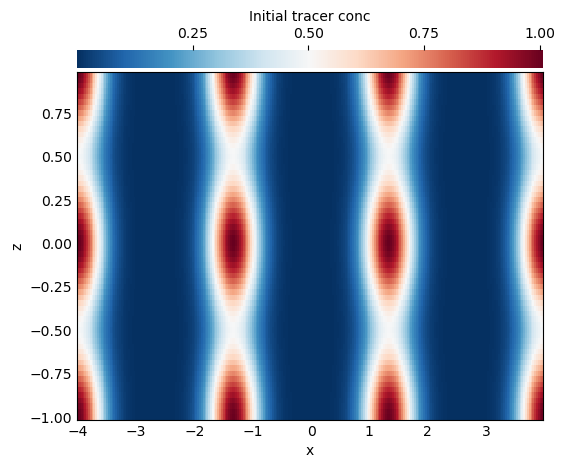

In [10]:
from dedalus.extras.plot_tools import plot_bot_2d
plot_bot_2d(C,title="Initial tracer conc");

The next few lines setup the way that the data will be saved.

In [11]:
# Analysis
sim_dt = 0.25
max_writes = stop_sim_time/sim_dt
data_fname = 'snapshots'
snapshots = solver.evaluator.add_file_handler(data_fname, 
                                              sim_dt=sim_dt, 
                                              max_writes=max_writes)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(u, name='uvec')
snapshots.add_task(p, name='pressure')
snapshots.add_task(C, name='tracer')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [12]:
# CFL (adapt time step as needed)
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [13]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2025-02-19 11:57:10,306 __main__ 0/1 INFO :: Starting main loop
2025-02-19 11:57:11,307 __main__ 0/1 INFO :: Iteration=1, Time=1.250000e-01, dt=1.250000e-01
2025-02-19 11:57:11,542 __main__ 0/1 INFO :: Iteration=11, Time=1.375000e+00, dt=1.250000e-01
2025-02-19 11:57:11,872 __main__ 0/1 INFO :: Iteration=21, Time=2.140616e+00, dt=7.656157e-02
2025-02-19 11:57:12,179 __main__ 0/1 INFO :: Iteration=31, Time=2.523423e+00, dt=3.828078e-02
2025-02-19 11:57:12,499 __main__ 0/1 INFO :: Iteration=41, Time=2.841419e+00, dt=3.179953e-02
2025-02-19 11:57:12,715 __main__ 0/1 INFO :: Iteration=51, Time=3.159414e+00, dt=3.179953e-02
2025-02-19 11:57:12,913 __main__ 0/1 INFO :: Iteration=61, Time=3.477409e+00, dt=3.179953e-02
2025-02-19 11:57:13,229 __main__ 0/1 INFO :: Iteration=71, Time=3.851266e+00, dt=3.738568e-02
2025-02-19 11:57:13,542 __main__ 0/1 INFO :: Iteration=81, Time=4.386762e+00, dt=5.354961e-02
2025-02-19 11:57:13,863 __main__ 0/1 INFO :: Iteration=91, Time=5.149437e+00, dt=7.626745e-

# Plot the solution 

In [14]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import dedalus.public as d3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr

In [15]:
simdata = './snapshots/snapshots_s1.h5'

In [16]:
# See what is in the data files
with h5py.File(simdata, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (9 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_4ed81b13f0aa908bb9caefe50f9a8b6a31597485', 'z_hash_65f3ebdbcb657c9267ce1ace1566dac45ab827ca']
<HDF5 group "/tasks" (4 members)>
['buoyancy', 'pressure', 'tracer', 'uvec']


In [17]:
# Actually read in data files
with h5py.File(simdata, mode='r') as file:
    
    b_data = np.squeeze(np.array(file['tasks']['buoyancy']))
    print('b shape: ' + str(b_data.shape))
    u_data = np.squeeze(np.array(file['tasks']['uvec']))
    print('u_data: ' + str(u_data.shape))
    p_data = np.squeeze(np.array(file['tasks']['pressure']))
    print('p_data: ' + str(p_data.shape))
    c_data = np.squeeze(np.array(file['tasks']['tracer']))
    print('c_data: ' + str(p_data.shape))
    #vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    #div_data = np.squeeze(np.array(file['tasks']['divergence']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary.shape)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    z = np.array(file['scales'][list(file['scales'])[-1]])
    

b shape: (300, 256, 64)
u_data: (300, 2, 256, 64)
p_data: (300, 256, 64)
c_data: (300, 256, 64)
(300,)


In [18]:
# Put data in xarray, as it is nice way to keep things organized
ds_sim = xr.Dataset()

ds_sim['b'] = xr.DataArray(b_data, coords = {'time':sim_time_ary, 'x':x, 'z':z})
ds_sim['p'] = xr.DataArray(p_data, coords = {'time':sim_time_ary, 'x':x, 'z':z})
ds_sim['u'] = xr.DataArray(u_data[:,0,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':x, 'z':z})
ds_sim['w'] = xr.DataArray(u_data[:,0,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':x, 'z':z})
ds_sim['c'] = xr.DataArray(c_data, coords = {'time':sim_time_ary, 'x':x, 'z':z})


In [19]:
ds_sim

<xarray.Dataset>
Dimensions:  (time: 300, x: 256, z: 64)
Coordinates:
  * time     (time) float64 0.0 0.25 0.5 0.75 1.0 ... 74.02 74.26 74.51 74.76
  * x        (x) float64 -4.0 -3.969 -3.938 -3.906 ... 3.875 3.906 3.938 3.969
  * z        (z) float64 -1.0 -0.9688 -0.9375 -0.9062 ... 0.9062 0.9375 0.9688
Data variables:
    b        (time, x, z) float64 0.0 0.0 0.0 0.0 ... 0.352 0.4063 0.4487 0.4757
    p        (time, x, z) float64 0.0 0.0 0.0 0.0 ... -0.02567 -0.0177 -0.009032
    u        (time, x, z) float64 0.0 0.0 0.0 0.0 ... 0.03216 0.02287 0.01189
    w        (time, x, z) float64 0.0 0.0 0.0 0.0 ... 0.03216 0.02287 0.01189
    c        (time, x, z) float64 1.004 1.0 0.9861 0.9628 ... 0.212 0.212 0.212

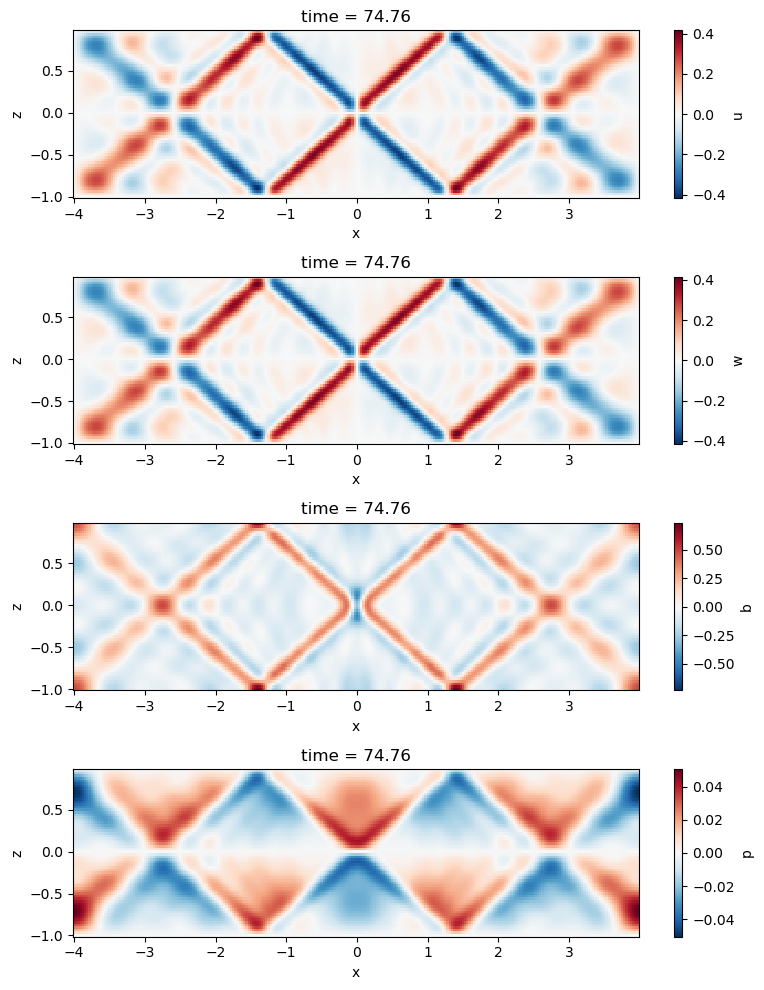

In [20]:
plt.figure(figsize=(8, 10))
plt.subplot(4,1,1)
ds_sim.u.isel(time=-1).plot(x='x')

plt.subplot(4,1,2)
ds_sim.w.isel(time=-1).plot(x='x')

plt.subplot(4,1,3)
ds_sim.b.isel(time=-1).plot(x='x')

plt.subplot(4,1,4)
ds_sim.p.isel(time=-1).plot(x='x')

plt.tight_layout()

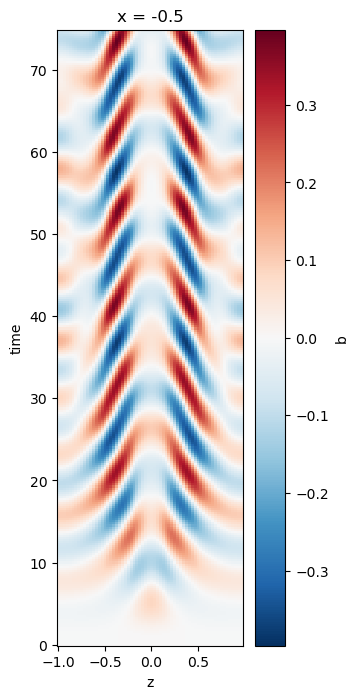

In [21]:
plt.figure(figsize=(3, 8))
#plt.pcolormesh(x, y, b_data[20, :,:].T)
ds_sim.b.sel(x=-0.5, method='nearest').plot(x='z')

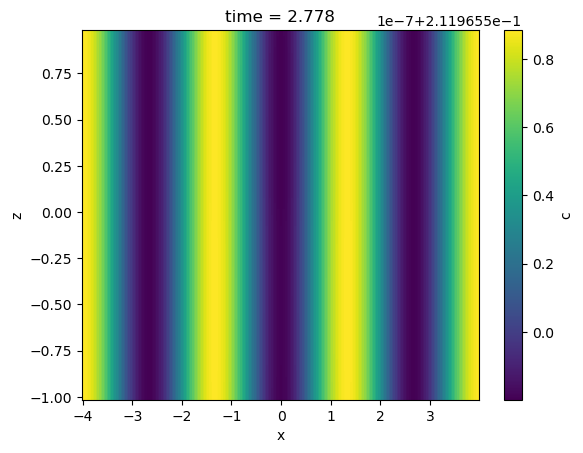

In [25]:
ds_sim.c.isel(time=11).plot(x='x')

Make a movie of a certain field

In [22]:
def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [23]:
# This function needs to be modified as needed if you want to make other movies
def plot_fun(time_idx): 
    vmin=-1 
    fig = plt.figure(figsize=(6, 2))
    
    ds_sim.b.isel(time=time_idx).plot(x='x', vmin=vmin)
    plt.gca().set_aspect('equal')
    
    plt.title(f"{sim_time_ary[time_idx]:.2f} s")

    plt.tight_layout()
    

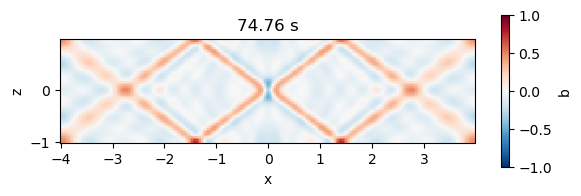

In [24]:
plot_fun(-1)

In [ ]:
fname = 'GW.gif'
create_animation(plot_fun, range(0, len(sim_time_ary), 1), filename=fname)